## FRB180301

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lmfit
import cPickle as pkl

import astropy.time
import astropy.coordinates
import astropy.units

import dedispersion
import filterbankio
import frbutils

%matplotlib inline

In [2]:
sns.set()
sns.set_context("notebook", rc={"lines.linewidth": 1.0})

### Parameters

In [3]:
# FRB180301.fil from 

frbStr = 'FRB180301'
frbFil = '/home/griffin/data/FRB/FRB180301/FRB180301.fil' # Filterbank file of FRB event (watermark)

### Dynamic Spectrum

In [4]:
### dynamic spectrum parameters
timeFactor = 1
freqFactor = 1
dm = 521.

start_time = 2.82 # seconds
time_window = 0.051 # seconds

applyGauss = True
fGauss = 2. # bins
tGauss = 0.1 # bins

rfi = []
#rfi = [[205,235], [940,1023]] # frequency channels to flag as rfi, pairs are the edges of bands

In [5]:
decwaterfall, decddwaterfall, tInt, freqs = frbutils.dynamicSpectrum(frbFil, start_time, time_window,
                                                timeFactor=timeFactor, freqFactor=freqFactor,
                                                dm=dm,
                                                applyGauss=applyGauss, fGauss=fGauss, tGauss=tGauss,
                                                rfi=rfi)

#### TIme Series

In [6]:
ddTimeSeries = np.mean(decddwaterfall, axis=1)

In [7]:
#plt.plot(np.mean(decddwaterfall, axis=0))
print np.mean(decddwaterfall, axis=0).shape

print decddwaterfall.shape

normdecddwaterfall = decddwaterfall - np.mean(decddwaterfall, axis=0)
print normdecddwaterfall.shape

(704,)
(174, 704)
(174, 704)


**Frequency Response**

In [8]:
peakIdx = np.unravel_index(np.argmax(normdecddwaterfall), normdecddwaterfall.shape)
print peakIdx
tWidth = 4

(89, 477)


#### Stokes I Plot

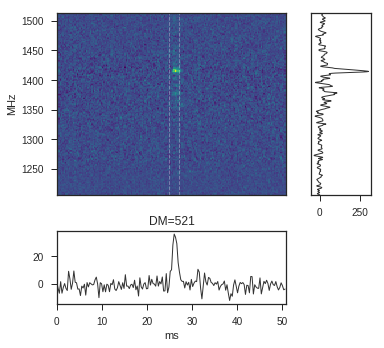

In [9]:
cmap = 'viridis'
sns.set_style('white', rc={'axes.linewidth': 0.5})
sns.set_style("ticks")

fig = plt.figure(figsize=(5.5,5)) # (width, height)

ax1 = plt.subplot2grid((3, 4), (0, 0), colspan=3, rowspan=2)

imRaw = plt.imshow(np.flipud(normdecddwaterfall.T), extent=(0, tInt*decddwaterfall.shape[0],\
                        freqs[0], freqs[-1]), aspect='auto', cmap=plt.get_cmap(cmap), interpolation='nearest')
# crop out RFI flagged high freqs
#imRaw = plt.imshow(np.flipud(decddwaterfall[:,:850].T), extent=(0, tInt*decddwaterfall.shape[0],\
#                        freqs[0], freqs[850]), aspect='auto', cmap=plt.get_cmap(cmap), interpolation='nearest')
for rfiPair in rfi:
    plt.axhspan(freqs[rfiPair[0]/freqFactor], freqs[rfiPair[1]/freqFactor], alpha=0.4, color='y')

#plt.scatter(tInt*peakIdx[0], freqs[peakIdx[1]])
plt.axvline(x=tInt*(peakIdx[0]-tWidth), c='w', lw=1, ls='--', alpha=0.3)
plt.axvline(x=tInt*(peakIdx[0]+tWidth), c='w', lw=1, ls='--', alpha=0.3)
plt.ylabel('MHz')

ax1.get_xaxis().set_visible(False)

ax2 = plt.subplot2grid((3, 4), (2, 0), colspan=3)
lineColor = 'k'
plt.plot(1000.*tInt*np.arange(decddwaterfall.shape[0]), ddTimeSeries- ddTimeSeries.mean(), lineColor, alpha=0.8)
plt.xlim(0, 1000.*tInt*ddTimeSeries.shape[0])
#plt.axvline(x=1000*tInt*(peakIdx[0]-tWidth), c='r', lw=1, ls='--', alpha=0.4)
#plt.axvline(x=1000*tInt*(peakIdx[0]+tWidth), c='r', lw=1, ls='--', alpha=0.4)
plt.title('DM=%0.f'%dm)
plt.xlabel('ms')
#ax2.get_yaxis().set_visible(False)

ax3 = plt.subplot2grid((3, 4), (0, 3), colspan=1, rowspan=2)

plt.plot(np.mean(normdecddwaterfall[peakIdx[0]-tWidth:peakIdx[0]+tWidth], axis=0), freqs, 'k', alpha=0.8)
plt.ylim(freqs[0], freqs[-1])

ax3.get_yaxis().set_visible(False)
#ax3.get_xaxis().set_visible(False)

plt.tight_layout()
plt.savefig('../figures/%s_dynamic.pdf'%(frbStr))
plt.savefig('../figures/%s_dynamic.png'%(frbStr))